In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

2025-08-10 23:31:24.050433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-10 23:31:24.050521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-10 23:31:24.053426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-10 23:31:24.068681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-10 23:31:25.215245: W tensorflow/compiler/tf2

In [2]:
SEED = 1234

In [3]:
training_set = pd.read_csv("../../../data/training_set.csv", parse_dates=['date'])
validation_set = pd.read_csv("../../../data/validation_set.csv", parse_dates=['date'])
test_set = pd.read_csv("../../../data/test_set.csv", parse_dates=['date'])


In [4]:
# Convertir a numpy arrays
x_train = training_set.drop(columns=['target_trend','date']).values
y_train = training_set['target_trend'].values
x_validation = validation_set.drop(columns=['target_trend','date']).values
y_validation = validation_set['target_trend'].values
x_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values    

IMPORTANTE: Hay que sumar a la columna de prediccion porque -1 no funciona en funcion de LOSS

In [5]:
y_train += 1
y_validation += 1
y_test += 1

In [6]:
x_train.shape[1]

50

Compilacion y entrenamiento de la red

In [7]:
# Setear la semilla para reproducibilidad
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# Definición de hiperparámetros
learning_rate = 0.001
n_l1 = 100 #100
n_l2 = 60  #60
n_l3 = 30  #30
n_l4 = 10  #10

# Definición del modelo
model = Sequential(
    [               
        tf.keras.Input(shape=(x_train.shape[1],)),
        Dense(n_l1,activation='relu',name='L1'),
        Dense(n_l2,activation='relu',name='L2'),
        Dense(n_l3,activation='relu',name='L3'),
        Dense(n_l4,activation='relu',name='L4'),
        Dense(3,activation='linear',name='L5'),
    ], name = "multiclass"
)
# Compilación del modelo
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy']
)
# Detiene el entrenamiento si val_loss no mejora después de 10 épocas seguidas
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# checkpoint = ModelCheckpoint(
#     filepath='best_model.keras',
#     monitor='val_loss',
#     save_best_only=True
# )
history = model.fit(
    x_train,y_train,
    epochs=60,
    validation_data=(x_validation, y_validation),
    callbacks=[early_stop]
)


2025-08-10 23:31:27.097706: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-10 23:31:27.639409: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/60
19/19 [==============================] - 1s 15ms/step - loss: 4858.4111 - accuracy: 0.2970 - val_loss: 1173.6089 - val_accuracy: 0.1385
Epoch 2/60
19/19 [==============================] - 0s 5ms/step - loss: 293.7975 - accuracy: 0.3399 - val_loss: 306.1024 - val_accuracy: 0.2000
Epoch 3/60
19/19 [==============================] - 0s 6ms/step - loss: 125.3327 - accuracy: 0.3020 - val_loss: 188.4226 - val_accuracy: 0.5077
Epoch 4/60
19/19 [==============================] - 0s 6ms/step - loss: 135.2214 - accuracy: 0.3713 - val_loss: 106.1689 - val_accuracy: 0.3154
Epoch 5/60
19/19 [==============================] - 0s 6ms/step - loss: 65.7126 - accuracy: 0.4274 - val_loss: 295.9713 - val_accuracy: 0.1846
Epoch 6/60
19/19 [==============================] - 0s 4ms/step - loss: 131.8009 - accuracy: 0.4422 - val_loss: 69.1015 - val_accuracy: 0.5154
Epoch 7/60
19/19 [==============================] - 0s 4ms/step - loss: 79.3804 - accuracy: 0.4340 - val_loss: 76.9369 - val_accuracy: 

In [8]:
model.summary()

Model: "multiclass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 100)               5100      
                                                                 
 L2 (Dense)                  (None, 60)                6060      
                                                                 
 L3 (Dense)                  (None, 30)                1830      
                                                                 
 L4 (Dense)                  (None, 10)                310       
                                                                 
 L5 (Dense)                  (None, 3)                 33        
                                                                 
Total params: 13333 (52.08 KB)
Trainable params: 13333 (52.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


GUARDADO EN .CSV DE LOS PARAMETROS DE LOS MODELOS ENTRENADOS

In [ ]:
# # Inicializar lista para guardar resultados
# resultados = []
# # Calcula métricas en validation
# loss, acc = model.evaluate(x_validation, y_validation, verbose=0)
# y_pred_val = np.argmax(model.predict(x_validation), axis=1)
# f1 = f1_score(y_validation, y_pred_val, average='macro')

# # Guarda los resultados y los hiperparámetros usados
# resultados.append({
#     'run': len(resultados)+1,
#     'val_loss': loss,
#     'val_accuracy': acc,
#     'val_f1_macro': f1,
#     'epochs': len(history.history['loss']),
#     'learning_rate': learning_rate,
#     'n_l1': n_l1,
#     'n_l2': n_l2,
#     'n_l3': n_l3,
#     'n_l4': n_l4,
#     #'n_l5': n_l5,
#     # Agregar mas parametros si es necesario
# })
# # Convierte la lista de resultados a DataFrame
# df_nuevos = pd.DataFrame(resultados)

# # Si el archivo ya existe, lo leemos y concatenamos
# csv_path = 'resultados_entrenamientos.csv'
# if os.path.exists(csv_path):
#     df_existente = pd.read_csv(csv_path)
#     df_final = pd.concat([df_existente, df_nuevos], ignore_index=True)
# else:
#     df_final = df_nuevos

# # Guardamos el DataFrame combinado
# df_final.to_csv(csv_path, index=False)

In [9]:
loss, accuracy = model.evaluate(x_validation, y_validation)

5/5 [==============================] - 0s 2ms/step - loss: 18.6718 - accuracy: 0.8077


Grafica de Loss y Accuracy en train_set & validation_set

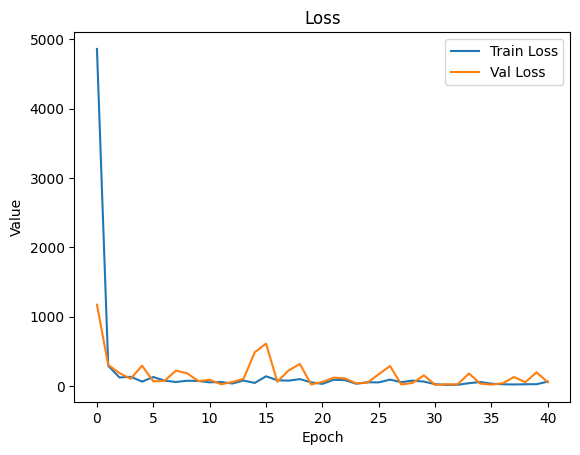

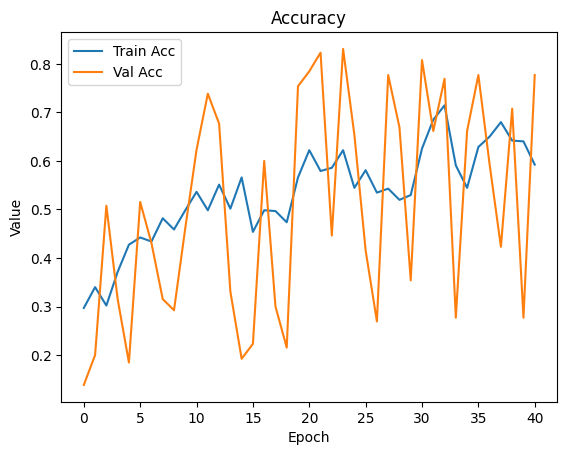

In [10]:
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()


F1 SCORE

In [11]:
# Obtener predicciones
y_pred_val = np.argmax(model.predict(x_validation), axis=1)
# Reporte completo: precisión, recall y F1 por clase
print("Validación:")
print(confusion_matrix(y_validation, y_pred_val))
print(classification_report(y_validation, y_pred_val))


5/5 [==============================] - 0s 2ms/step
Validación:
[[19  4  1]
 [ 6  2 10]
 [ 0  4 84]]
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        24
           1       0.20      0.11      0.14        18
           2       0.88      0.95      0.92        88

    accuracy                           0.81       130
   macro avg       0.61      0.62      0.61       130
weighted avg       0.77      0.81      0.78       130



In [12]:
def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(y_df["is_changed_trend_test"][:-1], y_df["is_changed_trend_predict"][:-1], digits=4)

In [13]:
print(trend_changes_score(y_test=y_validation, y_pred=y_pred_val))

              precision    recall  f1-score   support

       False     0.9074    0.8750    0.8909       112
        True     0.3333    0.4118    0.3684        17

    accuracy                         0.8140       129
   macro avg     0.6204    0.6434    0.6297       129
weighted avg     0.8318    0.8140    0.8221       129

